In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
import folium
import branca

In [3]:
perth = pd.read_csv('PerthHousing.csv', parse_dates=['date_sold'], infer_datetime_format=True)

train_indices, test_indices = train_test_split(np.array(perth.index), test_size=0.2, random_state=0)

train = perth.loc[train_indices].copy()
test = perth.loc[test_indices].copy()

train["log_price"] = np.log(train["price"])

In [4]:
sample_train = train.iloc[:10_000].copy()

In [5]:
q1 = train['log_price'].quantile(0.3)
q2 = train['log_price'].quantile(0.7)

def quantile_map(x):
    if x < q1: 
        return 1
    elif q1 <= x < q2:
        return 2
    return 3

train['price_quantile'] = train['log_price'].map(quantile_map)

In [7]:
x_train = train.loc[:, ['longitude', 'latitude']]
y_train = train['price_quantile']

In [18]:
scores = []  # List to save accuracy of models
for max_leaf_nodes in range(2, 50):
    model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, random_state=42)
    model.fit(x_train, y_train)
    
    # Compute Accuracy of Model and Save to list
    # You should also compute the accuracy on the validation data (not the test data)
    # But I'm not too bothered
    scores.append(model.score(x_train, y_train))
    
    if max_leaf_nodes % 5 == 0:
        print("Finished", max_leaf_nodes)

Finished 5
Finished 10
Finished 15
Finished 20
Finished 25
Finished 30
Finished 35
Finished 40
Finished 45


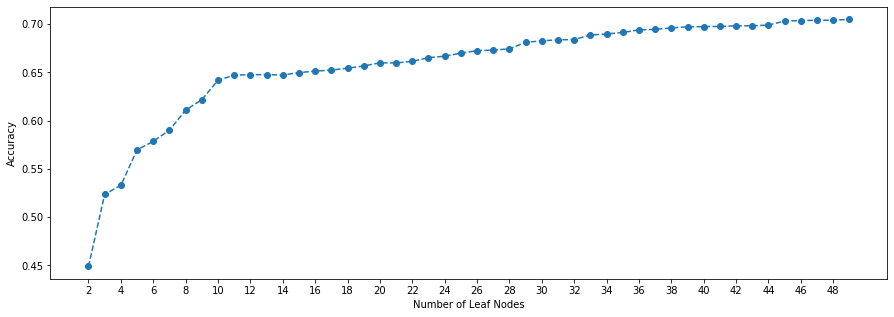

In [19]:
plt.figure(figsize=(15, 5))

plt.plot(np.arange(2, 50), scores, "--o")

plt.xticks(np.arange(2, 50, 2), np.arange(2, 50, 2));

plt.ylabel("Accuracy")
plt.xlabel("Number of Leaf Nodes");

In [30]:
model = RandomForestClassifier(max_leaf_nodes=10, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(max_leaf_nodes=10, random_state=42)

In [31]:
predicted_quantiles = model.predict(sample_train.loc[:, ["longitude", "latitude"]])

In [ ]:
price = predicted_quantiles
colormap = branca.colormap.linear.YlOrRd_09.scale(0, max(price))

folium_map = folium.Map(location=(-31.96, 115.87), zoom_start=9)

for i in range(len(sample_train)):
    values = sample_train.iloc[i, :]
    lat = values["latitude"]
    lon = values["longitude"]
    price = predicted_quantiles[i]

    color = colormap(price)
    folium.CircleMarker([lat, lon], radius=0.01, color=color,
                        popup=price,
                        fill=True, fill_opacity=0.7).add_to(folium_map)
    
folium_map.add_child(colormap)
folium_map

In [33]:
df = pd.DataFrame()

df["price"] = train["price"].copy()
df["log-price"] = np.log(train["price"]).copy()
df["log_price"] = np.log(train["price"])
df["labels"] = model.predict(train.loc[:, ["longitude", "latitude"]])
df["bedrooms"] = train["bedrooms"].copy()

In [ ]:
df.boxplot("price", "labels")

In [ ]:
sns.lmplot(y='log_price', x="bedrooms", data=df, hue='labels')

In [36]:
min_lon = train["longitude"].min()
max_lon = train["longitude"].max()

min_lat = train["latitude"].min()
max_lat = train["latitude"].max()

In [37]:
new_locations = []

for lon in np.linspace(min_lon, max_lon, 100):
    for lat in np.linspace(min_lat, max_lat, 100):
        new_locations.append((lon, lat))

In [38]:
x_temp = pd.DataFrame(new_locations, columns=["longitude", "latitude"])

predicted_quantiles = model.predict(x_temp)

In [ ]:
price = predicted_quantiles
colormap = branca.colormap.linear.YlOrRd_09.scale(0, max(price))

folium_map = folium.Map(location=(-31.96, 115.87), zoom_start=9)

for i in range(len(x_temp)):
    values = x_temp.iloc[i, :]
    lat = values["latitude"]
    lon = values["longitude"]
    price = predicted_quantiles[i]

    color = colormap(price)
    folium.CircleMarker([lat, lon], radius=0.01, color=color,
                        fill=True, opacity=0.5).add_to(folium_map)
    
folium_map.add_child(colormap)
folium_map

In [ ]:
df = pd.DataFrame()

df["log_price"] = train["log_price"]
df["longitude"] = train["longitude"].copy()
df["latitude"] = train["latitude"].copy()

In [ ]:
price = df["log_price"]
colormap = branca.colormap.linear.YlOrRd_09.scale(min(price), max(price))

folium_map = folium.Map(location=(-31.96, 115.87), zoom_start=9)

for i in range(10_000):
    values = df.iloc[i, :]
    lat = values["latitude"]
    lon = values["longitude"]
    price = values["log_price"]

    color = colormap(price)
    folium.CircleMarker([lat, lon], radius=0.01, color=color,
                        fill=True, fill_opacity=0.7).add_to(folium_map)
    
folium_map.add_child(colormap)
folium_map